# Dimensional reduction with PHATE: AT2 and COPD

Kynon J Benjamin  
2024-04-25

# 1. Import libraries

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import phate, scprep, session_info
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%matplotlib inline
sc.settings.verbosity = 3

# 2. Load data

In [3]:
adata = sc.read_h5ad("../../_m/ipf_dataset.h5ad")
adata

AnnData object with n_obs × n_vars = 312928 × 45947
    obs: 'CellBarcode_Identity', 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'cell_type', 'location', 'disease', 'patient', 'label'
    var: 'Ensembl_GeneID', 'HGNC_EnsemblAlt_GeneID'
    uns: 'X_name', 'study'

### 2.0.1 Subset for AT2 cell type

In [4]:
adata.obs.cell_type.unique()

['ncMonocyte', 'Macrophage_Alveolar', 'NK', 'cMonocyte', 'Lymphatic', ..., 'VE_Peribronchial', 'Pericyte', 'Aberrant_Basaloid', 'Ionocyte', 'PNEC']
Length: 39
Categories (39, object): ['ATI', 'ATII', 'Aberrant_Basaloid', 'B', ..., 'cDC2', 'cMonocyte', 'ncMonocyte', 'pDC']

In [5]:
new_adata = adata[adata.obs["cell_type"] == "ATII"]
new_adata

View of AnnData object with n_obs × n_vars = 3961 × 45947
    obs: 'CellBarcode_Identity', 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'cell_type', 'location', 'disease', 'patient', 'label'
    var: 'Ensembl_GeneID', 'HGNC_EnsemblAlt_GeneID'
    uns: 'X_name', 'study'

### 2.0.2 Convert to counts matrix

In [6]:
ipf_counts = pd.DataFrame(new_adata.X.toarray(), 
                          columns=[new_adata.var.index],
                          index=new_adata.obs.index)
print(ipf_counts.shape)
ipf_counts.head(2)

(3961, 45947)

2 rows × 45947 columns

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


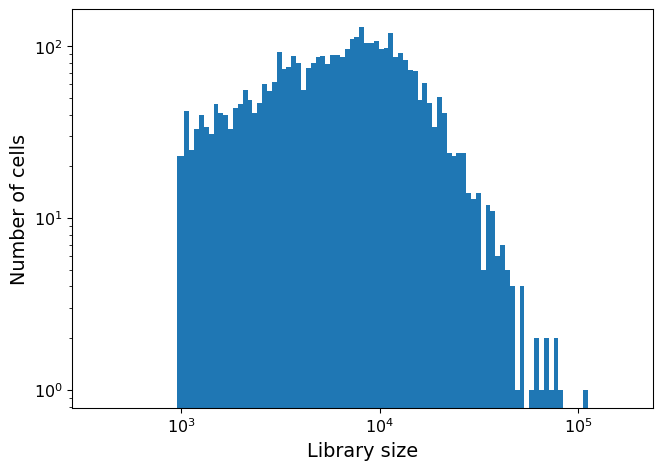

In [7]:
scprep.plot.plot_library_size(ipf_counts)

# 3. Preprocessing: Filtering, Normalizing, and Transforming

## 3.1 Filtering

In [8]:
ipf_counts = scprep.filter.filter_rare_genes(ipf_counts, min_cells=6)
ipf_counts.shape

(3961, 25358)

## 3.2 Normalization

In [9]:
ipf_counts = scprep.normalize.library_size_normalize(ipf_counts)
ipf_counts.head(2)

2 rows × 25358 columns

## 3.3 Transformation

In [10]:
ipf_counts = scprep.transform.sqrt(ipf_counts)

# 4. PHATE

In [11]:
phate_operator = phate.PHATE(n_jobs=-2, random_state=13)
Y_phate = phate_operator.fit_transform(ipf_counts)

Calculating PHATE...
  Running PHATE on 3961 observations and 25358 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.92 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 11.49 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.24 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.97 seconds.
  Calculated landmark operator in 4.82 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 3.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.67 seconds.
Calculated PHATE in 25.83 seconds.

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


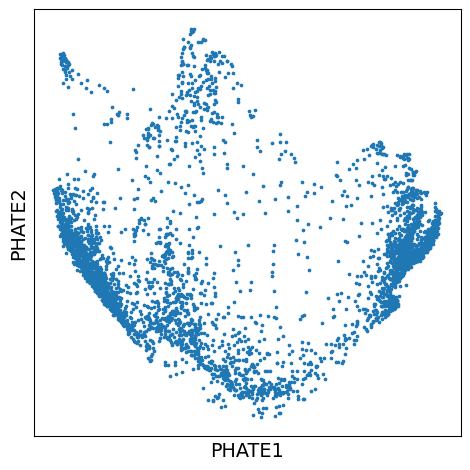

In [12]:
scprep.plot.scatter2d(Y_phate, ticks=None, label_prefix="PHATE", figsize=(5,5),
                      filename="at2_phate_clustering.pdf", dpi=300)

# 5. Plotting

## 5.1 Angiotensin II receptor 2 (AGTR2)

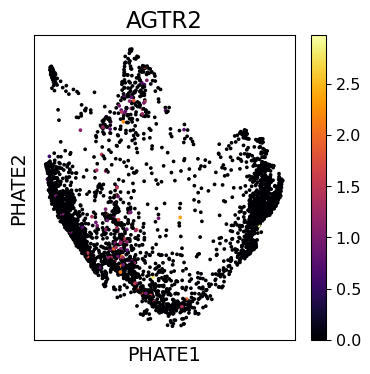

In [13]:
# Plotting mitochondrial expression
fig, ax = plt.subplots(1, figsize=(4,4))
scprep.plot.scatter2d(Y_phate, ax=ax, c=ipf_counts['AGTR2'],
                      title='AGTR2', ticks=False, label_prefix='PHATE',
                      filename="at2_phate_clustering.AGTR1.pdf", dpi=300)
fig.tight_layout()

## 5.2 KDE plot of pericytes

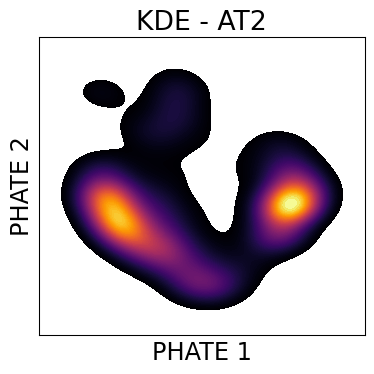

In [14]:
fig, ax = plt.subplots(1, figsize=(4,4))
kde_plot = sns.kdeplot(x=Y_phate[:, 0], y=Y_phate[:, 1], fill=True, ax=ax, zorder=0, 
                       n_levels=100, cmap="inferno")

ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel('PHATE 1', fontsize=18); ax.set_ylabel('PHATE 2', fontsize=18)
ax.set_title('KDE - AT2', fontsize=20)
fig.tight_layout()

fig = kde_plot.get_figure()
fig.savefig("at2_phate_kde.pdf") 

## 5.3 Clustering data using PHATE

/users/jbenjami/.local/lib/python3.9/site-packages/phate/cluster.py:57: FutureWarning:

k is deprecated. Please use n_clusters in future.

/users/jbenjami/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


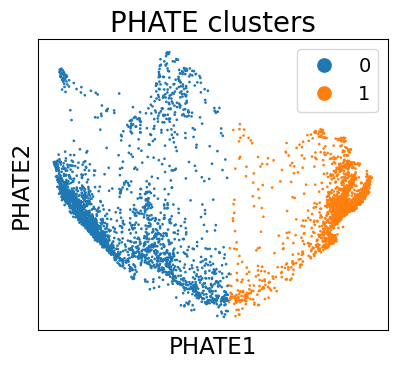

In [15]:
clusters = phate.cluster.kmeans(phate_operator, k=2)

scprep.plot.scatter2d(Y_phate, c=clusters, s=1,figsize=(4.3,4), ticks=None, label_prefix='PHATE',
                      legend_anchor=(1,1), fontsize=12, title='PHATE clusters',
                      filename="at2_phate_clustering.kmeans.pdf", dpi=300)

fig.tight_layout()

# 6. Comparison of PHATE clusters and AGTR2 expressoin

## 6.1 Subset data

In [16]:
gene_list = []
for item in ipf_counts.columns:
    gene_list.append(str(item).replace("('", "").replace("',)", ""))

new_adata = new_adata[ipf_counts.index, new_adata.var.index.isin(gene_list)]
new_adata.obsm["X_phate"] = Y_phate
new_adata.obs["phate_clusters"] = ["Group_"+str(clu) for clu in clusters]
new_adata

/tmp/ipykernel_3068809/2896849848.py:6: ImplicitModificationWarning:

Setting element `.obsm['X_phate']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 3961 × 25358
    obs: 'CellBarcode_Identity', 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'cell_type', 'location', 'disease', 'patient', 'label', 'phate_clusters'
    var: 'Ensembl_GeneID', 'HGNC_EnsemblAlt_GeneID'
    uns: 'X_name', 'study'
    obsm: 'X_phate'

## 6.2 Qualitative review

In [17]:
ipf_counts.loc[:, "PHATE"] = clusters
ipf_counts.loc[:, "patient"] = new_adata.obs["patient"]
ipf_counts.loc[:, "disease"] = new_adata.obs["disease"]
df = pl.from_pandas(ipf_counts.loc[:, ["AGTR2", "PHATE", "patient", "disease"]])\
       .rename({"('AGTR2',)": "AGTR2", "('PHATE',)": "PHATE", 
                "('patient',)": "patient", "('disease',)": "disease"})
df.head()

In [18]:
df.write_csv("at2_phate.normalized_expression.tsv", separator="\t")

In [19]:
df.filter(pl.col("AGTR2") > 0)\
  .group_by(["PHATE", "patient", "disease"])\
  .agg([pl.sum("AGTR2").name.suffix("_sum"), 
        pl.mean("AGTR2").name.suffix("_mean"),
        pl.count("AGTR2").name.suffix("_count"),
        pl.std("AGTR2").name.suffix("_std")])\
  .sort("PHATE")

In [20]:
df.filter(pl.col("AGTR2") > 0)\
  .group_by(["PHATE", "disease"])\
  .agg([pl.sum("AGTR2").name.suffix("_sum"), 
        pl.mean("AGTR2").name.suffix("_mean"),
        pl.count("AGTR2").name.suffix("_count"),
        pl.std("AGTR2").name.suffix("_std")])\
  .sort("PHATE")

In [21]:
dx = df.filter(pl.col("PHATE") == 1, pl.col("AGTR2") > 0).group_by(["patient", "disease"]).agg(pl.mean("AGTR2"))
dx.head(2)

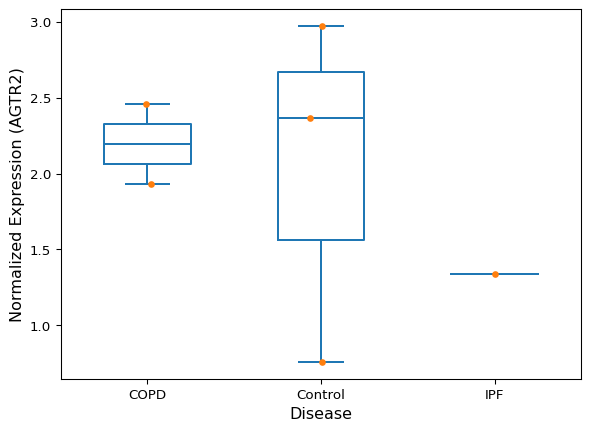

In [22]:
ax = sns.boxplot(data=dx, x="disease", y="AGTR2", fill=False, width=0.5)
box_plot = sns.stripplot(data=dx, x="disease", y="AGTR2", ax=ax)
ax.set_xlabel('Disease', fontsize=12); 
ax.set_ylabel('Normalized Expression (AGTR2)', fontsize=12)
fig.tight_layout()
fig = box_plot.get_figure()
fig.savefig("at2_phate.PHATE_cluster_1.boxplot_AGTR2.pdf") 

## 6.3 Statistical comparison

### 6.3.1 One-way ANOVA

In [23]:
c0 = dx.filter(pl.col("disease") == "Control").to_pandas().AGTR2.values
c1 = dx.filter(pl.col("disease") == "COPD").to_pandas().AGTR2.values
c2 = dx.filter(pl.col("disease") == "IPF").to_pandas().AGTR2.values

f_oneway(c0, c1, c2)

F_onewayResult(statistic=0.27937860330302505, pvalue=0.773988205432517)

### 6.3.2 TukeyHSD

In [24]:
model = MultiComparison(dx.to_pandas().AGTR2, dx.to_pandas().disease)
res_mod = model.tukeyhsd()
print(res_mod)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   COPD Control  -0.1616 0.9815 -3.8185 3.4953  False
   COPD     IPF  -0.8576 0.7647 -5.7639 4.0486  False
Control     IPF   -0.696  0.816 -5.3217 3.9297  False
-----------------------------------------------------

### 6.3.3 T-test (two-sided)

In [25]:
ttest_ind(c0, c1) # Control VS COPD

Ttest_indResult(statistic=-0.1846704770781784, pvalue=0.8652661565736242)

In [26]:
ttest_ind(c0, c2) # Control VS IPF

/users/jbenjami/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning:

Degrees of freedom <= 0 for slice

/users/jbenjami/.local/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide


Ttest_indResult(statistic=nan, pvalue=nan)

In [27]:
ttest_ind(c1, c2) # COPD VS IPF

Ttest_indResult(statistic=nan, pvalue=nan)

### 6.3.4 Mann-Whitney U

#### 6.3.4.1 Two-sided test

In [28]:
mannwhitneyu(c0, c1) # Control VS COPD

MannwhitneyuResult(statistic=3.0, pvalue=1.0)

In [29]:
mannwhitneyu(c0, c2) # Control VS IPF

MannwhitneyuResult(statistic=2.0, pvalue=1.0)

In [30]:
mannwhitneyu(c1, c2) # COPD VS IPF

MannwhitneyuResult(statistic=2.0, pvalue=0.6666666666666666)

#### 6.3.4.2 One-sided test

In [31]:
mannwhitneyu(c0, c1, alternative="less") # Control VS COPD

MannwhitneyuResult(statistic=3.0, pvalue=0.6000000000000001)

In [32]:
mannwhitneyu(c0, c2, alternative="less") # Control VS IPF

MannwhitneyuResult(statistic=2.0, pvalue=0.75)

In [33]:
mannwhitneyu(c1, c2, alternative="greater") # COPD VS IPF

MannwhitneyuResult(statistic=2.0, pvalue=0.3333333333333333)

# 7. Session information

In [34]:
session_info.show()

Click to view session information 
 
-----
anndata 0.10.5.post1
matplotlib 3.7.1
numpy 1.24.4
pandas 2.0.3
phate 1.0.11
polars 0.19.12
scanpy 1.9.8
scipy 1.8.1
scprep 1.2.3
seaborn 0.13.2
session_info 1.0.0
statsmodels 0.14.0
-----
 
 
 Click to view modules imported as dependencies 
 
PIL 8.2.0
anyio NA
argcomplete NA
arrow 1.2.3
asttokens NA
attr 23.2.0
attrs 23.2.0
babel 2.10.3
backcall 0.2.0
beta_ufunc NA
binom_ufunc NA
cairo 1.20.1
certifi 2024.02.02
cffi 1.14.5
chardet 4.0.0
charset_normalizer 3.3.2
cloudpickle 2.1.0
comm 0.2.2
contourpy 1.1.0
cycler 0.10.0
cython_runtime NA
dask 2022.8.1
dateutil 2.8.2
debugpy 1.6.3
decorator 5.1.1
deprecated 1.2.13
exceptiongroup 1.2.0
executing 0.10.0
fastjsonschema NA
fontTools 4.33.3
fqdn NA
fsspec 2022.7.1
future 0.18.2
gi 3.40.1
gio NA
glib NA
gobject NA
graphtools 1.5.3
gtk NA
h5py 3.7.0
hypergeom_ufunc NA
idna 2.10
igraph 0.10.4
importlib_metadata NA
importlib_resources NA
ipykernel 6.15.1
ipywidgets 8.1.2
isoduration NA
jedi 0.19.1
jinja2 3.1.1
joblib 1.2.0
json5 NA
jsonpointer 2.3
jsonschema 4.21.1
jsonschema_specifications NA
jupyter_events 0.10.0
jupyter_server 2.13.0
jupyterlab_server 2.25.4
kaleido 0.2.1
kiwisolver 1.4.3
leidenalg 0.9.1
llvmlite 0.42.0
louvain 0.8.1
lxml 4.9.1
markupsafe 2.1.1
matplotlib_inline 0.1.6
mpl_toolkits NA
natsort 8.2.0
nbformat 5.4.0
nbinom_ufunc NA
netifaces 0.10.6
numba 0.59.0
opt_einsum v3.3.0
overrides NA
packaging 21.3
parso 0.8.3
patsy 0.5.2
pexpect 4.8.0
pickleshare 0.7.5
pkg_resources NA
platformdirs 3.8.0
plotly 5.9.0
ply 3.11
prometheus_client NA
prompt_toolkit 3.0.30
psutil 5.9.1
ptyprocess 0.7.0
pure_eval 0.2.2
pyarrow 15.0.0
pycparser 2.20
pydev_ipython NA
pydevconsole NA
pydevd 2.8.0
pydevd_file_utils NA
pydevd_plugins NA
pydevd_tracing NA
pygments 2.13.0
pygsp 0.5.1
pyparsing 3.0.9
pythonjsonlogger NA
pytz 2022.1
referencing NA
requests 2.31.0
rfc3339_validator 0.1.4
rfc3986_validator 0.1.1
rpds NA
s_gd2 1.8.1
send2trash NA
six 1.16.0
sklearn 1.4.1.post1
sniffio 1.2.0
socks 1.7.1
stack_data 0.4.0
swig_runtime_data4 NA
tasklogger 1.2.0
tenacity NA
texttable 1.6.7
threadpoolctl 3.1.0
tlz 0.12.0
toolz 0.12.0
torch 1.13.1+cu117
tornado 6.2
tqdm 4.64.0
traitlets 5.9.0
typing_extensions NA
uri_template NA
urllib3 1.26.5
wcwidth 0.2.5
webcolors 1.11.1
websocket 1.4.0
wrapt 1.16.0
yaml 6.0
zipp NA
zmq 25.0.0
zoneinfo NA
zstandard 0.18.0
 
 <!-- seems like this ends pre, so might as well be explicit -->
 
-----
IPython 8.4.0
jupyter_client 8.0.2
jupyter_core 5.2.0
jupyterlab 4.1.5
notebook 7.1.2
-----
Python 3.9.16 (main, Dec 8 2022, 00:00:00) [GCC 11.3.1 20221121 (Red Hat 11.3.1-4)]
Linux-5.14.0-284.11.1.el9_2.x86_64-x86_64-with-glibc2.34
-----
Session information updated at 2024-04-26 11:57